In [1]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [2]:
# #Use CPU because of GPU OOM issue
config = tf.ConfigProto(
#     allow_soft_placement=True,
#     log_device_placement=True
#     device_count = {'GPU':0}
)

x = tf.placeholder(tf.float32, [None, 784]) #x is placeholder for 28 * 28 image
y_ = tf.placeholder(tf.float32, [None, 10])
x_image = tf.reshape (x, [-1,28,28,1], name="x_image") #change input data from a list to a 28 x 28 x 1 grayscale cube

def weight_variable(shape):
    initial = tf.truncated_normal(shape,stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME') #k is kernel
# Define layers
W_conv1 = weight_variable([5, 5, 1, 32]) #32 features for each 5x5 size of filer, 1 channel grayscale
b_conv1 = bias_variable([32])

h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1) # convolution
h_pool1 = max_pool_2x2(h_conv1) # max pooling
W_conv2 = weight_variable([5, 5, 32, 64]) #64 features
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)
# Fully Connected Layer
W_fc1 = weight_variable([7 * 7 * 64, 1024]) # 7x7 images by 64 features to 1024 neuron 
b_fc1 = bias_variable([1024])
# connect output of pooling 2 to fc layer
h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
#dropout
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)
#Readout
W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])

#Define model
y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

#Loss measurement
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_conv,labels=y_))
                               
#Loss optimization
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
#correct
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
#accurate
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

9.94197
step 0, elapsed time 1.02 seconds, training accuracy 14.000%
1.22988
step 100, elapsed time 1.76 seconds, training accuracy 78.000%
0.584673
step 200, elapsed time 2.49 seconds, training accuracy 92.000%
0.531222
step 300, elapsed time 3.23 seconds, training accuracy 92.000%
0.225706
step 400, elapsed time 3.98 seconds, training accuracy 94.000%
0.150484
step 500, elapsed time 4.71 seconds, training accuracy 100.000%
0.123719
step 600, elapsed time 5.43 seconds, training accuracy 98.000%
0.190096
step 700, elapsed time 6.18 seconds, training accuracy 92.000%
0.268061
step 800, elapsed time 6.91 seconds, training accuracy 94.000%
0.56904
step 900, elapsed time 7.63 seconds, training accuracy 90.000%
0.197727
step 1000, elapsed time 8.35 seconds, training accuracy 96.000%
0.0625295
step 1100, elapsed time 9.29 seconds, training accuracy 100.000%
0.0749612
step 1200, elapsed time 10.02 seconds, training accuracy 96.000%
0.170851
step 1300, elapsed time 10.76 seconds, training accu

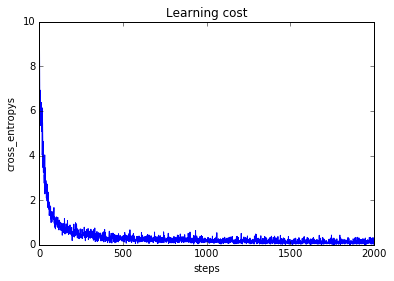

Test accuracy 97.740%


In [3]:
import time
import matplotlib.pyplot as plt
import numpy as np

#Train
with tf.Session(config=config) as sess:
    sess.run(tf.global_variables_initializer())

    num_steps = 2000
    display_every = 100
    cross_entropys = []

    #start timer
    start_time = time.time()
    end_time = time.time()

    for i in range(num_steps):
        batch = mnist.train.next_batch(50)
#         train_step.run(feed_dict={x: batch[0], y_: batch[1], keep_prob:0.5})
        _ , temp_cost = sess.run([train_step,cross_entropy],feed_dict={x: batch[0], y_: batch[1], keep_prob:0.5})

        cross_entropys.append(temp_cost)
        if i%display_every == 0:
            train_accuracy = accuracy.eval(feed_dict={x:batch[0], y_:batch[1], keep_prob: 1.0})
            end_time = time.time()
            print(temp_cost)
            print("step {0}, elapsed time {1:.2f} seconds, training accuracy {2:.3f}%".format(i, end_time - start_time, train_accuracy*100))
    #Display summary
    end_time = time.time()
    print("Total training time for {0} batches: {1:.2f} seconds".format(i+1, end_time-start_time))

    # plot the cost
    plt.plot(np.squeeze(cross_entropys))
    plt.ylabel('cross_entropys')
    plt.xlabel('steps')
    plt.title("Learning cost")
    plt.show()
    
    # Accuracy on test data
    # print("Test accuracy {0:.3f}%".format(accuracy.eval(feed_dict={x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0})*100.0))
    # mnist.test.image.shape is (10000,784).In a 10k batch, it takes 2GB for this layer and lead to OOM
    batch_size = 50
    batch_num = int(mnist.test.num_examples / batch_size)
    test_accuracy = 0
    for i in range(batch_num):
        batch = mnist.test.next_batch(batch_size)
        test_accuracy += accuracy.eval(feed_dict={x: batch[0],
                                                  y_: batch[1],
                                                  keep_prob: 1.0})

    test_accuracy /= batch_num
    print("Test accuracy {0:.3f}%".format(test_accuracy*100.0))